# Application to Mock HSC Data

This notebook applies the results from Part 2 (run over mock SDSS data) to mock HSC data.

# Setup

In [1]:
from __future__ import print_function, division
import sys
import pickle
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
from six.moves import range

# import frankenz code
import frankenz

# plot in-line within the notebook
%matplotlib inline

np.random.seed(20)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

# Data

Let's import our mock HSC data.

In [3]:
survey = pickle.load(open('../data/mock_hsc_polletta_bpz.pkl', 'rb'))  # load data
types = survey.data['types']  # type flag
templates = survey.data['templates']  # template ID
redshifts = survey.data['redshifts']  # redshift
mags = survey.data['refmags']  # magnitude (reference)
phot_obs = survey.data['phot_obs']  # observed photometry
phot_err = survey.data['phot_err']  # photometry error
phot_true = survey.data['phot_true']  # true photometry
Nobs = len(types)

In [4]:
# compute color loglikelihoods over grid
mphot = survey.models['data'].reshape(-1, survey.NFILTER)
merr = np.zeros_like(mphot)
mmask = np.ones_like(mphot)
mzgrid = survey.models['zgrid']
mredshifts = np.array([mzgrid for i in range(survey.NTEMPLATE)]).T.flatten()
ttypes = np.array([np.arange(survey.NTYPE)[t['type'] == survey.TYPES] 
                   for t in survey.templates], dtype='int').flatten()

In [5]:
# dividing into training/testing samples
sel = (phot_obs / phot_err)[:, survey.ref_filter] > 5.  # S/N > 5 cut
Nsel = sel.sum()

Ntrain, Ntest = 75000, 10000
train_sel = np.arange(Nobs)[sel][:Ntrain]  # training set
test_sel = np.arange(Nobs)[sel][Ntrain:Ntrain+Ntest]  # testing set
Nmodel = len(mphot)

print('Number of observed galaxies (all):', Nobs)
print('Number of observed galaxies (selected):', Nsel)
print('Number of models:', Nmodel)
print('Number of training galaxies:', Ntrain)
print('Number of testing galaxies:', Ntest)

Number of observed galaxies (all): 200000
Number of observed galaxies (selected): 88205
Number of models: 31000
Number of training galaxies: 75000
Number of testing galaxies: 10000


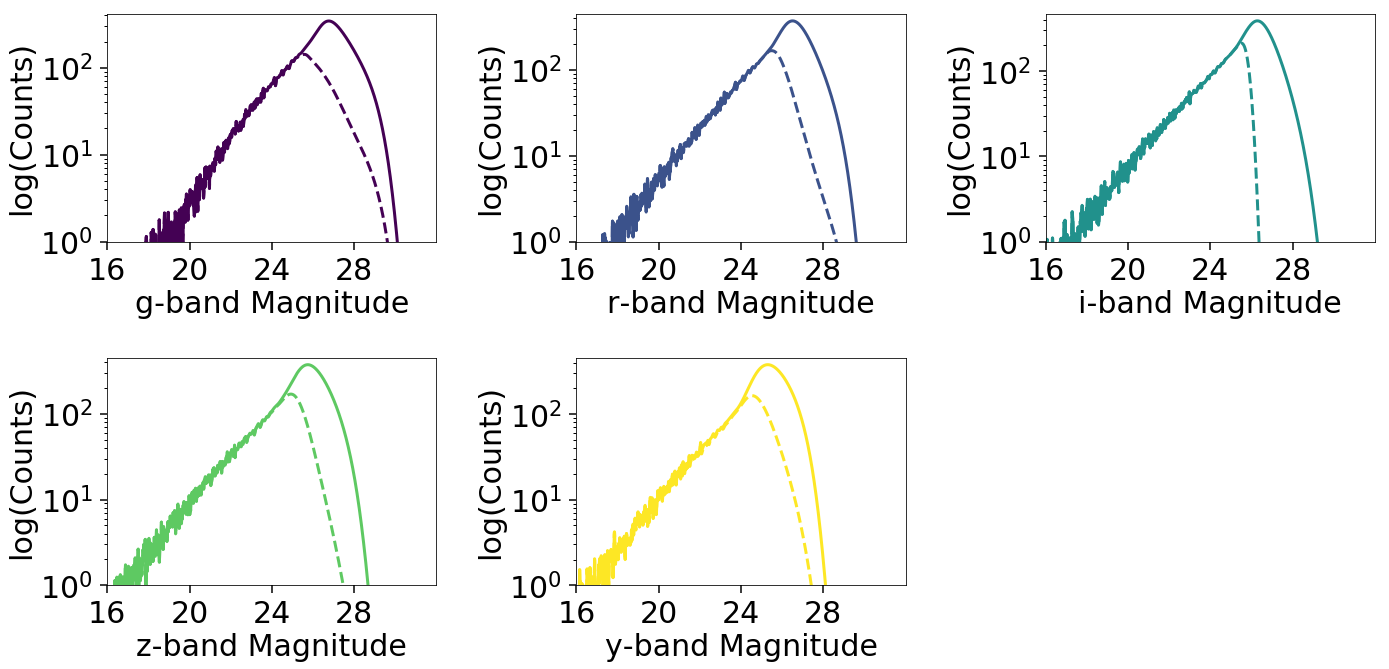

In [6]:
# initialize asinh magnitudes ("Luptitudes")
flux_zeropoint = 10**(-0.4 * -23.9) # AB magnitude zeropoint
fdepths = np.array([f['depth_flux1sig'] for f in survey.filters])
mag, magerr = frankenz.pdf.asinh_mag(phot_obs, phot_err, skynoise=fdepths,
                                     zeropoints=flux_zeropoint)

# initialize magnitude dictionary 
mdict = frankenz.pdf.PDFDict(pdf_grid=np.arange(-20., 60., 5e-3), 
                             sigma_grid=np.linspace(0.01, 5., 500))

# plotting magnitude distribution
fcolors = plt.get_cmap('viridis')(np.linspace(0,1, survey.NFILTER))
plt.figure(figsize=(20, 10))
for i in range(survey.NFILTER):
    plt.subplot(2, int(survey.NFILTER/2)+1, i+1)
    # compute pdf
    mag_pdf = frankenz.pdf.gauss_kde_dict(mdict, y=mag[:, i],
                                          y_std=magerr[:, i])  # all
    plt.semilogy(mdict.grid, mag_pdf, lw=3, color=fcolors[i])
    magsel_pdf = frankenz.pdf.gauss_kde_dict(mdict, y=mag[sel, i],
                                             y_std=magerr[sel, i])  # selected
    plt.semilogy(mdict.grid, magsel_pdf, lw=3, color=fcolors[i], ls='--')
    plt.xlim([16, 32])
    plt.ylim([1., mag_pdf.max() * 1.2])
    plt.xticks(np.arange(16, 30, 4))
    plt.xlabel(survey.filters[i]['name'] + '-band Magnitude')
    plt.ylabel('log(Counts)')
    plt.tight_layout()

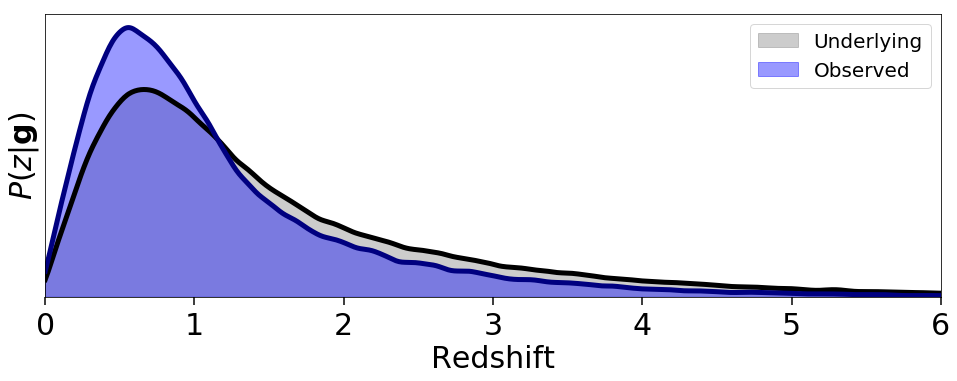

In [7]:
# initialize redshift dictionary
rdict = frankenz.pdf.PDFDict(pdf_grid=np.arange(0., 8.+1e-5, 0.01), 
                             sigma_grid=np.linspace(0.005, 2., 500))

# plotting redshift distribution
plt.figure(figsize=(14, 6))
rsmooth = 0.05

# all
z_pdf = frankenz.pdf.gauss_kde_dict(rdict, y=redshifts,
                                    y_std=np.ones_like(redshifts) * rsmooth)
plt.plot(rdict.grid, z_pdf / z_pdf.sum(), lw=5, color='black')
plt.fill_between(rdict.grid, z_pdf / z_pdf.sum(), color='gray',
                 alpha=0.4, label='Underlying')

# selected
zsel_pdf = frankenz.pdf.gauss_kde_dict(rdict, y=redshifts[sel],
                                       y_std=np.ones_like(redshifts[sel]) * rsmooth)
plt.plot(rdict.grid, zsel_pdf / zsel_pdf.sum(), lw=5, color='navy')
plt.fill_between(rdict.grid, zsel_pdf / zsel_pdf.sum(), 
                 color='blue', alpha=0.4, label='Observed')

# prettify
plt.xlim([0, 6])
plt.ylim([0, None])
plt.yticks([])
plt.legend(fontsize=20)
plt.xlabel('Redshift')
plt.ylabel('$P(z|\mathbf{g})$')
plt.tight_layout()

# Fits

Let's now initialize our catalogs and compute our fits.

In [8]:
# initialize datasets
phot_train, phot_test = phot_obs[train_sel], phot_obs[test_sel]
err_train, err_test = phot_err[train_sel], phot_err[test_sel]
mask_train, mask_test = np.ones_like(phot_train), np.ones_like(phot_test)

In [9]:
# initialize kNNMC instance
knn = frankenz.nn.KMCkNN()
idxs, Nidxs = knn.query(phot_train, err_train, phot_test, err_test)

Finding neighbors: 25/25          
Selecting unique neighbors: 10000/10000          

In [10]:
# compute individual PDFs
from scipy.special import logsumexp
zpdfs_fz = np.zeros((Ntest, rdict.Ngrid))
chi2min_fz = np.zeros(Ntest)
levid_fz = np.zeros(Ntest)
ztrain = redshifts[train_sel]
for i, (idx, Nidx) in enumerate(zip(idxs, Nidxs)):
    if i%500 == 0: 
        sys.stderr.write(str(i)+' ')
    j = idx[:Nidx]
    ll, nbands, chi2 = frankenz.pdf.loglike(phot_test[i], err_test[i], mask_test[i],
                                            phot_train[j], err_train[j], mask_train[j])
    wt = np.exp(ll - logsumexp(ll))
    zpdfs_fz[i] = frankenz.pdf.gauss_kde_dict(rdict, y=ztrain[j], 
                                              y_std=np.zeros_like(j), 
                                              y_wt=wt)
    chi2min_fz[i] = min(chi2)
    levid_fz[i] = logsumexp(ll)

0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 9500 

In [11]:
zpdfs = np.zeros((Ntest, rdict.Ngrid))

for i in range(Ntest):
    if i%500 == 0: 
        sys.stderr.write(str(i)+' ')
    # get test object
    mag = mags[test_sel[i]]
    
    # derive log-likelihoods
    ll, nbands, chisq = frankenz.pdf.loglike(phot_test[i], err_test[i], mask_test[i],
                                             mphot, merr, mmask,
                                             ignore_model_err=True, free_scale=True)
    
    # add on prior
    prior = np.array([frankenz.priors.bpz_pz_tm(mzgrid, t, mag) for t in ttypes]).T.flatten()
    lpost = np.log(prior) + ll
    
    # compute stacked likelihoods/posteriors
    post = np.exp(lpost - logsumexp(lpost))
    zpdfs[i] = frankenz.pdf.gauss_kde_dict(rdict, y=mredshifts,
                                           y_std=np.zeros_like(mredshifts), 
                                           y_wt=post)

0 /home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log
500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 9500 

# Results

Let's see how we did.

In [12]:
# stack results
zpdf0 = frankenz.pdf.gauss_kde_dict(rdict, y=redshifts[test_sel],
                                    y_std=np.ones_like(test_sel) * rsmooth)
zpdf_fz = frankenz.pdf.gauss_kde_dict(rdict, y=rdict.grid,
                                      y_std=np.ones_like(rdict.grid) * rsmooth, 
                                      y_wt=zpdfs_fz.sum(axis=0))
zpdf = frankenz.pdf.gauss_kde_dict(rdict, y=rdict.grid,
                                   y_std=np.ones_like(rdict.grid) * rsmooth, 
                                   y_wt=zpdfs.sum(axis=0))

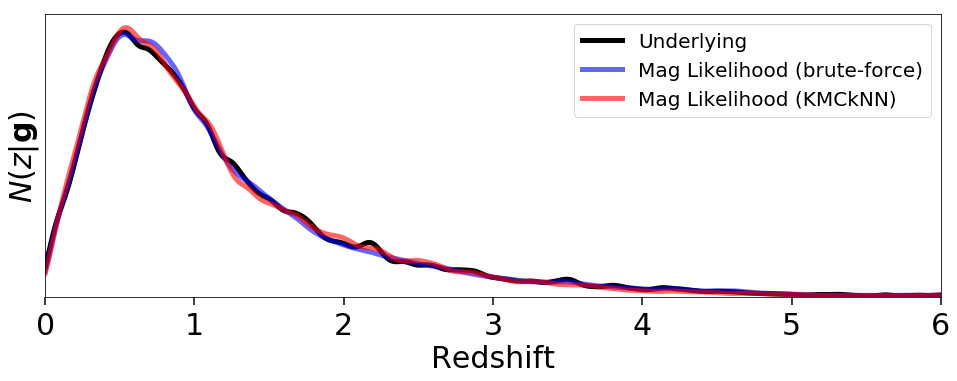

In [13]:
# plotting
plt.figure(figsize=(14, 6))
plt.plot(rdict.grid, zpdf0, lw=5, color='black',
         label='Underlying')
plt.plot(rdict.grid, zpdf, lw=5, color='blue', alpha=0.6,
         label='Mag Likelihood (brute-force)')
plt.plot(rdict.grid, zpdf_fz, lw=5, color='red', alpha=0.6,
         label='Mag Likelihood (KMCkNN)')
plt.xlim([0., 6.])
plt.ylim([0., None])
plt.yticks([])
plt.legend(fontsize=20)
plt.xlabel('Redshift')
plt.ylabel('$N(z|\mathbf{g})$')
plt.tight_layout()

Things look good so far.

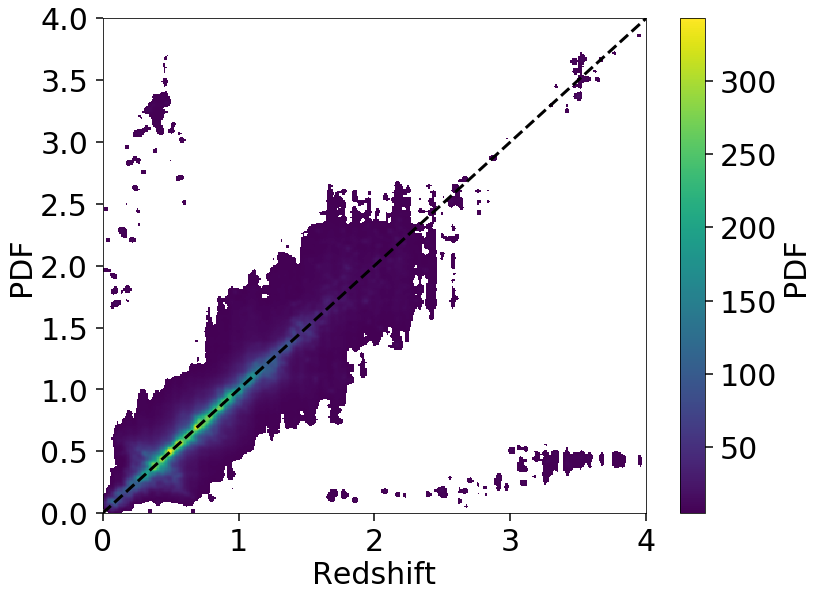

In [14]:
from frankenz import plotting as fzplot

# plot stacked PDFs
plt.figure(figsize=(12,9))
hh = fzplot.truth_vs_pdf(redshifts[test_sel], np.zeros_like(test_sel), 
                         zpdfs_fz, rdict, plot_thresh=5, smooth=1.5)
plt.xlabel('Redshift')
plt.ylabel('PDF')
plt.xlim([0., 4.])
plt.ylim([0., 4.])
plt.tight_layout()

Those look really nice as well.

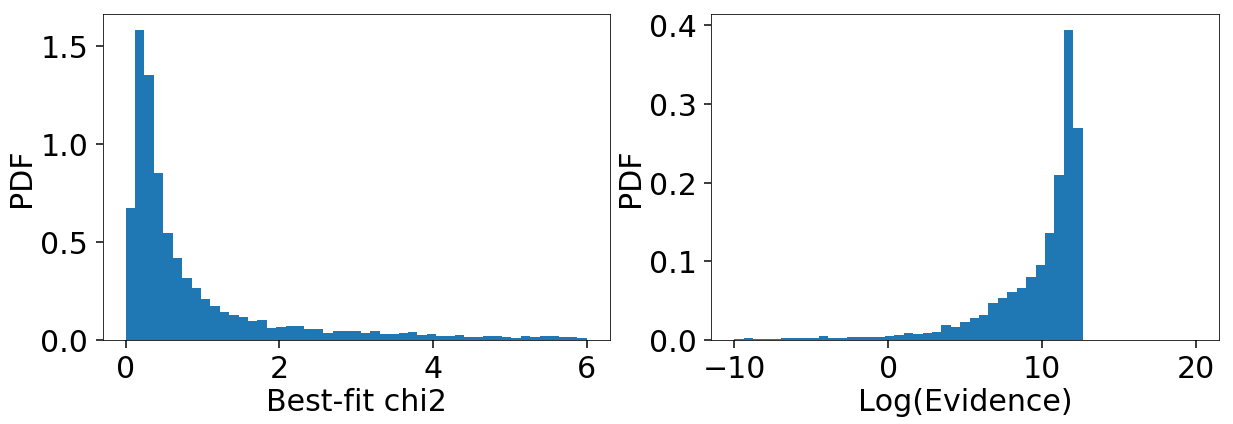

In [15]:
# plot chi2 distribution
plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
plt.hist(chi2min_fz, np.linspace(0, 6., 50), normed=True)
plt.xlabel('Best-fit chi2')
plt.ylabel('PDF')
plt.subplot(1,2,2)
plt.hist(levid_fz, np.linspace(-10, 20., 50), normed=True)
plt.xlabel('Log(Evidence)')
plt.ylabel('PDF');

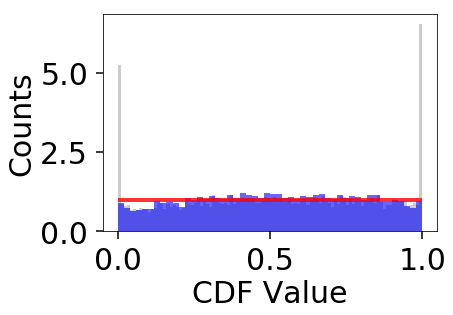

In [16]:
# compute CDF values
cval = np.array([np.interp(ztrue, rdict.grid, pdf.cumsum() / pdf.sum()) 
                 for ztrue, pdf in zip(redshifts[test_sel], zpdfs_fz)])

# plot results
csel = (chi2min_fz < 5)  # remove bad fits (~20% of sample)
plt.hist(cval, bins=np.linspace(0., 1., 101), 
         normed=True, color='black', alpha=0.2)  # all
plt.hist(cval[csel], bins=np.linspace(0., 1., 51), 
         normed=True, color='blue', alpha=0.6)  # w/o bad fits
plt.hlines(1., 0., 1., colors='red', lw=4, alpha=0.8)  # best-case result
plt.xlabel('CDF Value')
plt.ylabel('Counts');